In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.sparse import csr_matrix
%pprint

Pretty printing has been turned OFF


Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018.

In [2]:
dfl = pd.read_csv('Data/links.csv')
dfm = pd.read_csv('Data/movies.csv')
dfr = pd.read_csv('Data/ratings.csv')
dft = pd.read_csv('Data/tags.csv')

In [77]:
print(dfl.shape)
print(dfm.shape)
print(dfr.shape)
print(dft.shape)

(9742, 3)
(9742, 3)
(100836, 4)
(3683, 4)


In [78]:
print(dfl.columns)
print(dfm.columns)
print(dfr.columns)
print(dft.columns)

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')
Index(['movieId', 'title', 'genres'], dtype='object')
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')


In [79]:
user1 = dfr[dfr['userId'] == 1]
user1

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
227,1,3744,4.0,964980694
228,1,3793,5.0,964981855
229,1,3809,4.0,964981220
230,1,4006,4.0,964982903


In [3]:
df = dfr.drop(columns = "timestamp")
df['movieId'] = df['movieId']

In [4]:
df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [5]:
ur_matrix = df.pivot(index=['userId'], columns=['movieId'], values=['rating'])
ur_matrix.head()

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          4.0    NaN    4.0    NaN    NaN    4.0    NaN    NaN    NaN    NaN   
2          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5          4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

         ...                                                                 \
movieId  ... 193565 193567 193571 193573 193579 193581 193583 193585 193587   
userId   ...                                                                  
1        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 193609  
userId          
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  

[5 rows x 9724 columns]

In [6]:
csr_matrix = csr_matrix(df.astype(pd.SparseDtype("float64",0)).sparse.to_coo())

In [7]:
csr_matrix

<100836x3 sparse matrix of type '<class 'numpy.float64'>'
	with 302508 stored elements in Compressed Sparse Row format>

In [8]:
dfm.set_index('movieId', drop = False, inplace = True)

In [9]:
dfm.index.name = None

In [10]:
dfm

,movieId,title,genres
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,2,Jumanji (1995),Adventure|Children|Fantasy
3,3,Grumpier Old Men (1995),Comedy|Romance
4,4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
193581,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,193585,Flint (2017),Drama
193587,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


## Model base

In [11]:
# import necessary libraries and submodules
from surprise import Dataset, Reader
from surprise import SVD # implementation of Funk's SVD
from surprise import accuracy # metric
from surprise.model_selection import cross_validate, train_test_split #train/test splits, etc
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV

import numpy as np

In [12]:
df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [13]:
user_rating_matrix = df.pivot(index=['userId'], columns=['movieId'], values=['rating'])
user_rating_matrix.head()

rating                                                                 \
movieId 1      2      3      4      5      6      7      8      9      10       
userId                                                                          
1          4.0    NaN    4.0    NaN    NaN    4.0    NaN    NaN    NaN    NaN   
2          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4          NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5          4.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

         ...                                                                 \
movieId  ... 193565 193567 193571 193573 193579 193581 193583 193585 193587   
userId   ...                                                                  
1        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
5        ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                
movieId 193609  
userId          
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  

[5 rows x 9724 columns]

In [14]:
data = df

# suprise models take in the data in a specific format through a reader and dataset loader
reader = Reader(line_format='user item rating', sep=',')
data = Dataset.load_from_df(data, reader=reader)

In [15]:
trainset, testset = train_test_split(data, test_size=.2)

In [16]:
params = {'n_factors': [50, 100, 150], 'n_epochs': [60, 80, 100],
          'lr_all': [0.003, 0.005, 0.007], 'reg_all': [0.02, 0.05]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

In [17]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8536403414555715, 'mae': 0.652949108441238}
{'rmse': {'n_factors': 150, 'n_epochs': 100, 'lr_all': 0.007, 'reg_all': 0.05}, 'mae': {'n_factors': 150, 'n_epochs': 100, 'lr_all': 0.007, 'reg_all': 0.05}}


In [18]:
g_s_svd.best_estimator

{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x00000183D3130520>, 'mae': <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x00000183D31304C0>}

In [19]:
dataset = data.build_full_trainset()

In [20]:
svd = SVD(n_factors= 150, n_epochs= 100, lr_all= 0.007, reg_all= 0.05)
svd.fit(dataset)

In [21]:
predictions = svd.test(testset)
accuracy.rmse(predictions)

RMSE: 0.3349


0.3348820429920525

In [22]:
accuracy.mse(predictions)

MSE: 0.1121


0.1121459827185309

In [23]:
accuracy.fcp(predictions)

FCP:  0.9307


0.9307108513228071

In [24]:
list_of_movies = []
for m_id in df['movieId'].unique():
    list_of_movies.append( (m_id,svd.predict(1,m_id)[3]))

In [25]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [26]:
list_of_movies

[(1, 4.309071479695062), (3, 4.200284269012755), (6, 4.217033051472087), (47, 4.905573247035381), (50, 4.658143507519338), (70, 3.41359610094269), (101, 4.838062007767097), (110, 4.491208734711474), (151, 4.6255212502975365), (157, 4.66673287706145), (163, 4.5116765709368165), (216, 4.621333802214381), (223, 3.9175975261906695), (231, 4.500571452836159), (235, 4.142720998345201), (260, 4.963742234191116), (296, 4.149156481667234), (316, 3.4734817625814585), (333, 4.7857679592543185), (349, 4.104515024527242), (356, 4.872247975533055), (362, 4.713268393374076), (367, 3.9623584905177616), (423, 3.1718421868966153), (441, 4.174776241660476), (457, 4.741603550818228), (480, 4.297543453904165), (500, 3.770496917547615), (527, 4.832848685259791), (543, 4.212284778314125), (552, 3.9890984774613467), (553, 4.76765775981556), (590, 4.326899870677738), (592, 4.281483137943706), (593, 4.319411594197129), (596, 4.696570109288059), (608, 4.711060626721353), (648, 3.685950034633277), (661, 4.7671487

In [27]:
ranked_movies

[(1136, 5), (1196, 5), (1197, 5), (2137, 5), (2959, 5), (318, 5), (720, 5), (417, 5), (800, 5), (912, 5), (1250, 5), (3358, 5), (353, 5), (750, 5), (92259, 5), (858, 5), (1223, 5), (142488, 5), (177593, 5), (1217, 5), (1262, 5), (3451, 5), (3836, 5), (44195, 5), (246, 5), (306, 5), (51931, 5), (106100, 5), (26326, 5), (27156, 5), (170705, 5), (1235, 5), (3507, 5), (6460, 5), (171763, 5), (8014, 5), (1172, 5), (1041, 5), (6791, 5), (3606, 5), (78836, 5), (171495, 5), (59141, 5), (3951, 5), (5328, 5), (5490, 5), (181315, 5), (3940, 4.998413293944647), (1237, 4.997766238184372), (2078, 4.996748755601719), (1218, 4.996711445471278), (7234, 4.995917476706534), (136449, 4.995161282728276), (26810, 4.993859248971875), (5008, 4.992668288077953), (5416, 4.9879421329496605), (1221, 4.9874445731639385), (4002, 4.987418913956482), (1220, 4.982237145436579), (171011, 4.981443319101505), (96488, 4.981201604647184), (922, 4.981068489586031), (27773, 4.979415806983896), (90430, 4.974280801581816), (28

In [28]:
def recommended_movies(ranked_movies,dfm,n):
        for idx, rec in enumerate(ranked_movies):
            title = dfm.loc[dfm['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,dfm,5)

Recommendation #  1 :  1136    Monty Python and the Holy Grail (1975)
Name: title, dtype: object 

Recommendation #  2 :  1196    Star Wars: Episode V - The Empire Strikes Back...
Name: title, dtype: object 

Recommendation #  3 :  1197    Princess Bride, The (1987)
Name: title, dtype: object 

Recommendation #  4 :  2137    Charlotte's Web (1973)
Name: title, dtype: object 

Recommendation #  5 :  2959    Fight Club (1999)
Name: title, dtype: object 



In [29]:
dfm.loc[dfm['movieId'] == 260]

,movieId,title,genres
260,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi


In [30]:
svd.predict(1, 1)

Prediction(uid=1, iid=1, r_ui=None, est=4.309071479695062, details={'was_impossible': False})

#### Single Function

In [31]:
def custom_user_rec(user_id, dfm, n):
    
    list_of_movies = []
    for m_id in df['movieId'].unique():
        list_of_movies.append( (m_id,svd.predict(user_id,m_id)[3]))
        
    ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)
    
    recommended_movies(ranked_movies,dfm,n)
    

In [87]:
custom_user_rec(2, dfm, 10)

Recommendation #  1 :  131724    The Jinx: The Life and Deaths of Robert Durst ...
Name: title, dtype: object 

Recommendation #  2 :  80906    Inside Job (2010)
Name: title, dtype: object 

Recommendation #  3 :  60756    Step Brothers (2008)
Name: title, dtype: object 

Recommendation #  4 :  89774    Warrior (2011)
Name: title, dtype: object 

Recommendation #  5 :  122882    Mad Max: Fury Road (2015)
Name: title, dtype: object 

Recommendation #  6 :  5915    Victory (a.k.a. Escape to Victory) (1981)
Name: title, dtype: object 

Recommendation #  7 :  1236    Trust (1990)
Name: title, dtype: object 

Recommendation #  8 :  106782    Wolf of Wall Street, The (2013)
Name: title, dtype: object 

Recommendation #  9 :  60943    Frozen River (2008)
Name: title, dtype: object 

Recommendation #  10 :  7981    Infernal Affairs (Mou gaan dou) (2002)
Name: title, dtype: object 



In [68]:
usermovie = df.merge(dfm, how='left', on='movieId')

In [86]:
usermovie[usermovie['userId'] == 2].sort_values(by='rating', ascending= False)

,userId,movieId,rating,title,genres
260,2,131724,5.0,The Jinx: The Life and Deaths of Robert Durst ...,Documentary
259,2,122882,5.0,Mad Max: Fury Road (2015),Action|Adventure|Sci-Fi|Thriller
254,2,106782,5.0,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama
250,2,89774,5.0,Warrior (2011),Drama
241,2,60756,5.0,Step Brothers (2008),Comedy
248,2,80906,5.0,Inside Job (2010),Documentary
234,2,1704,4.5,Good Will Hunting (1997),Drama|Romance
240,2,58559,4.5,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
242,2,68157,4.5,Inglourious Basterds (2009),Action|Drama|War
247,2,80489,4.5,"Town, The (2010)",Crime|Drama|Thriller


## Content based filtering

In [110]:
movie_ids_tags = dft['movieId'].unique().astype('str').tolist()
movie_ids_genres = dfm['movieId'].unique().astype('str').tolist()
movie_genres_u = ["Action", "Adventure", "Animation", "Children's", "Comedy", 
           "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", 
           "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", 
           "Thriller", "War", "Western", "(no genres listed)"]
movie_genres_a = dfm['genres'].unique().tolist()
movie_tags = dft['tag'].str.lower().unique().tolist()

In [111]:
print(len(movie_ids_tags))
print(len(movie_ids_genres))
print(len(movie_tags))

1572
9742
1475


### Movie Genre Matrix

In [112]:
dfm_genres = dfm['genres']

In [113]:
dfm_genres.index

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            193565, 193567, 193571, 193573, 193579, 193581, 193583, 193585,
            193587, 193609],
           dtype='int64', length=9742)

In [114]:
dfm_genres[1]

'Adventure|Animation|Children|Comedy|Fantasy'

In [115]:
for x in dfm_genres.index:
    dfm_genres[x] = dfm_genres[x].split("|")

C:\Users\musaa\AppData\Local\Temp\ipykernel_5484\308654152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm_genres[x] = dfm_genres[x].split("|")


In [116]:
dfm_genres

1         [Adventure, Animation, Children, Comedy, Fantasy]
2                            [Adventure, Children, Fantasy]
3                                         [Comedy, Romance]
4                                  [Comedy, Drama, Romance]
5                                                  [Comedy]
                                ...                        
193581                 [Action, Animation, Comedy, Fantasy]
193583                         [Animation, Comedy, Fantasy]
193585                                              [Drama]
193587                                  [Action, Animation]
193609                                             [Comedy]
Name: genres, Length: 9742, dtype: object

In [117]:
pd.get_dummies(dfm_genres.apply(pd.Series).stack()).sum(level=0)

C:\Users\musaa\AppData\Local\Temp\ipykernel_5484\3213974333.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.get_dummies(dfm_genres.apply(pd.Series).stack()).sum(level=0)


,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
193583,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
193585,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
193587,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [118]:
m_g_matrix = pd.get_dummies(dfm_genres.apply(pd.Series).stack()).sum(level=0)

C:\Users\musaa\AppData\Local\Temp\ipykernel_5484\2696242451.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  m_g_matrix = pd.get_dummies(dfm_genres.apply(pd.Series).stack()).sum(level=0)


In [119]:
m_g_matrix.replace(0, np.nan, inplace = True)

In [120]:
m_g_matrix.describe()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,34.0,1828.0,1263.0,611.0,664.0,3756.0,1199.0,440.0,4361.0,779.0,87.0,978.0,158.0,334.0,573.0,1596.0,980.0,1894.0,382.0,167.0
mean,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Movie Tag Matrix

In [121]:
dft.set_index('movieId', drop = False, inplace = True)

In [122]:
dft_tags = dft['tag']

In [123]:
dft_tags = pd.Series(dft['tag'].str.lower())

In [124]:
dft_tags.sum(level=0)

C:\Users\musaa\AppData\Local\Temp\ipykernel_5484\1945606737.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dft_tags.sum(level=0)


movieId
60756     funnyhighly quotablewill ferrellcomedyfunnywil...
89774                              boxing storymmatom hardy
106782    drugsleonardo dicapriomartin scorsesestock mar...
48516     way too longleonardo dicapriosuspensetwist end...
431                                  al pacinogangstermafia
                                ...                        
1948                                                british
5694                                                   70mm
6107                                           world war ii
7936                                                austere
3265                                 gun fuheroic bloodshed
Name: tag, Length: 1572, dtype: object

In [125]:
dft

,userId,movieId,tag,timestamp
movieId,,,,
60756,2,60756,funny,1445714994
60756,2,60756,Highly quotable,1445714996
60756,2,60756,will ferrell,1445714992
89774,2,89774,Boxing story,1445715207
89774,2,89774,MMA,1445715200
...,...,...,...,...
7382,606,7382,for katie,1171234019
7936,606,7936,austere,1173392334
3265,610,3265,gun fu,1493843984


## Keras

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image

In [35]:
display(dfr)
display(dfm)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


,movieId,title,genres
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,2,Jumanji (1995),Adventure|Children|Fantasy
3,3,Grumpier Old Men (1995),Comedy|Romance
4,4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
193581,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,193585,Flint (2017),Drama
193587,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [36]:
g = dfr.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]

g = dfr.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]

top_r = dfr.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


In [37]:
user_enc = LabelEncoder()
dfr['user'] = user_enc.fit_transform(dfr['userId'].values)
n_users = dfr['user'].nunique()

item_enc = LabelEncoder()
dfr['movie'] = item_enc.fit_transform(dfr['movieId'].values)
n_movies = dfr['movie'].nunique()

dfr['rating'] = dfr['rating'].values.astype(np.float32)
min_rating = min(dfr['rating'])
max_rating = max(dfr['rating'])

n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

In [38]:
X = dfr[['user', 'movie']].values
y = dfr['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 2), (10084, 2), (90752,), (10084,))

In [39]:
n_factors = 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

### Model 1

In [43]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import adam_v2
from keras.regularizers import l2
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])    
    model = Model(inputs=[user, movie], outputs=x)
    opt = adam_v2.Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)    
    return model

In [44]:
(n_users, n_movies, n_factors)

(610, 9724, 50)

In [45]:
model1 = RecommenderV1(n_users, n_movies, n_factors)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        30500       ['input_2[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        486200      ['input_3[0][0]']                
                                                                                              

C:\Users\musaa\anaconda3\envs\Person-Projects\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [136]:
X_train_array[0].shape

(90752,)

In [137]:
history = model1.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
1418/1418 [==============================] - 7s 4ms/step - loss: 9.4573 - val_loss: 3.2652
Epoch 2/5
1418/1418 [==============================] - 6s 4ms/step - loss: 1.9767 - val_loss: 1.6187
Epoch 3/5
1418/1418 [==============================] - 6s 4ms/step - loss: 1.1038 - val_loss: 1.3535
Epoch 4/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.8463 - val_loss: 1.2724
Epoch 5/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7141 - val_loss: 1.2435


### Model 2

In [46]:
from keras.layers import Add, Activation, Lambda

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors,
                      embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
    
def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)    
    
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)    
    
    model = Model(inputs=[user, movie], outputs=x)
    opt = adam_v2.Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)    
    
    return model

In [47]:
model2 = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        30500       ['input_4[0][0]']                
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 50)        486200      ['input_5[0][0]']                
                                                                                            

In [140]:
history = model2.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
1418/1418 [==============================] - 8s 5ms/step - loss: 1.1938 - val_loss: 0.8551
Epoch 2/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.6995 - val_loss: 0.7570
Epoch 3/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.5347 - val_loss: 0.7369
Epoch 4/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.4067 - val_loss: 0.7406
Epoch 5/5
1418/1418 [==============================] - 7s 5ms/step - loss: 0.3121 - val_loss: 0.7555


### NN

In [48]:
from keras.layers import Concatenate, Dense, Dropout

def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)    
    
    model = Model(inputs=[user, movie], outputs=x)
    opt = adam_v2.Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)    
    
    return model

In [49]:
model3 = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 50)        30500       ['input_6[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 50)        486200      ['input_7[0][0]']                
                                                                                            

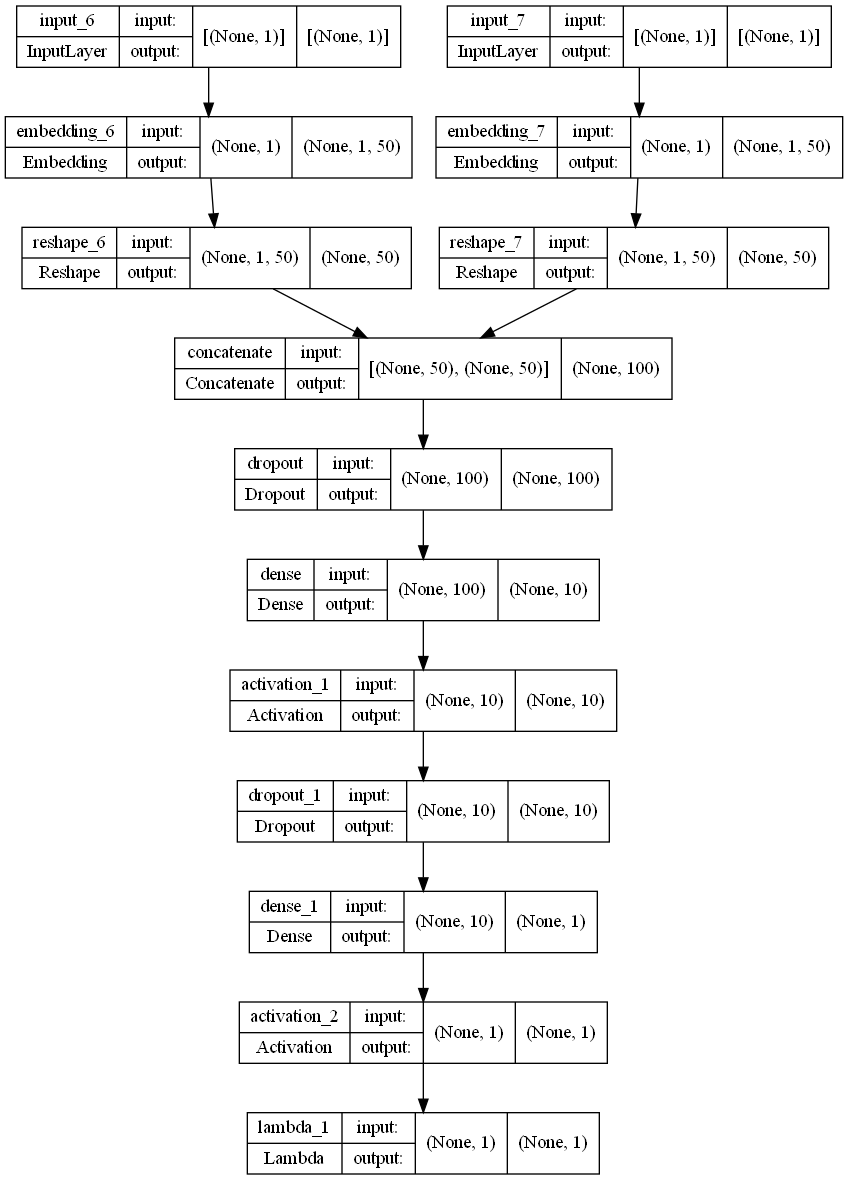

In [50]:
keras.utils.plot_model(model3, "my_first_model_with_shape_info.png", show_shapes=True)


In [51]:
history = model3.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
1418/1418 [==============================] - 8s 4ms/step - loss: 0.9090 - val_loss: 0.7933
Epoch 2/5
1418/1418 [==============================] - 5s 4ms/step - loss: 0.7640 - val_loss: 0.7810
Epoch 3/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7315 - val_loss: 0.7796
Epoch 4/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7147 - val_loss: 0.7784
Epoch 5/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7058 - val_loss: 0.7805


In [145]:
history.history

{'loss': [0.9426358938217163,
  0.7677626013755798,
  0.7281626462936401,
  0.7113313674926758,
  0.7023526430130005],
 'val_loss': [0.7920981645584106,
  0.7788633108139038,
  0.781795859336853,
  0.7773818373680115,
  0.7819340229034424]}

#### Predictions

In [52]:
results = model3.evaluate(X_test_array, y_test, batch_size=128)

79/79 [==============================] - 0s 2ms/step - loss: 0.7805


In [53]:
print("test loss, test acc:", results)

test loss, test acc: 0.7804672718048096


In [54]:
prediction = model3.predict(X_test_array)
print("prediction shape:", prediction.shape)

prediction shape: (10084, 1)


In [55]:
prediction.shape

(10084, 1)

In [56]:
y_test.shape

(10084,)